In [49]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 3)
plt.rc('text')
plt.rcParams.update({'font.size': 16})

import numpy as np
import tensorflow as tf

from gpflow.config import default_float
from gpflow.kernels import RBF, Matern52
from gpflow.models import GPR

from gpflux.layers.basis_functions.random_fourier_features import RandomFourierFeatures
from gpflux.sampling.kernel_with_mercer_decomposition import KernelWithMercerDecomposition

In [50]:
# settings that are fixed across experiments
kernel_class = RBF  # choose alternatively kernel_class = Matern52
noise_variance = 1e-3  # variance of the observation model
num_test_samples = 256  # number of test samples for evaluation (1024 in the paper)
num_experiment_runs = 32  # number of experiment repetitions (64 in the paper)

# settings that vary across experiments
num_input_dimensions = [2, 4, 8]  # number of input dimensions
train_sample_exponents = [2, 4, 6, 8, 10]  # num_train_samples = 2 ** train_sample_exponents
num_train_samples = [2 ** train_sample_exponent for train_sample_exponent in train_sample_exponents]
num_features = [1024, 4096, 16384]  # the actual number of features is num_features += num_train_samples

In [51]:
def compute_analytic_GP_predictions(X, y, kernel, noise_variance, X_star):
    """
    Identify the mean and covariance of an analytic GPR posterior for test point locations.
    :param X: train point locations of shape [N x D]
    :param y: train targets of shape [N x 1]
    :param kernel: kernel object
    :param noise_variance: variance of the observation model
    :param X_star: test point locations of shape [N* x D]
    :return: mean and covariance of the noise-free predictions of shape [N*] and [N* x N*] respectively
    """
    gpr_model = GPR(data=(X, y), kernel=kernel, noise_variance=noise_variance)
    
    f_mean, f_var = gpr_model.predict_f(X_star, full_cov=True)
    f_mean, f_var = f_mean[..., 0], f_var[0]
    assert f_mean.shape == (X_star.shape[0],)
    assert f_var.shape == (X_star.shape[0], X_star.shape[0])
    
    return f_mean, f_var

In [52]:
def compute_Matheron_predictions(X, y, exact_kernel, approximate_kernel, noise_variance, X_star):
    """
    Identify the mean and covariance using the Matheron approximation of the exact posterior.
    :param X: train point locations of shape [N x D]
    :param y: train targets of shape [N x 1]
    :param exact_kernel: the exact kernel object
    :param approximate_kernel: the approximate kernel object based on feature functions
    :param noise_variance: variance of the observation model
    :param X_star: test point locations of shape [N* x D]
    :return: mean and covariance of the noise-free predictions of shape [N*] and [N* x N*] respectively
    """
    phi_star = approximate_kernel._eigenfunctions(X_star)
    assert phi_star.shape[0] == X_star.shape[0]
    
    phi = approximate_kernel._eigenfunctions(X)
    assert phi.shape[0] == X.shape[0]

    kXstarX = exact_kernel.K(X_star, X)
    assert kXstarX.shape == (X_star.shape[0], X.shape[0])
    
    KXX = exact_kernel.K(X)
    kXX_plus_noise_var = tf.linalg.set_diag(KXX, tf.linalg.diag_part(KXX) + noise_variance)
    assert kXX_plus_noise_var.shape == (X.shape[0], X.shape[0])
    
    kXX_inv_mul_phi = tf.linalg.solve(kXX_plus_noise_var, phi)
    assert kXX_inv_mul_phi.shape[0] == X.shape[0]
    
    kXX_inv_mul_y = tf.linalg.solve(kXX_plus_noise_var, y)
    assert kXX_inv_mul_y.shape[0] == X.shape[0]

    f_mean = kXstarX @ kXX_inv_mul_y
    f_mean = f_mean[..., 0]
    assert f_mean.shape[0] == X_star.shape[0]
    
    f_var_sqrt = phi_star - kXstarX @ kXX_inv_mul_phi
    assert f_var_sqrt.shape[0] == X_star.shape[0]
    
    f_var = f_var_sqrt @ tf.transpose(f_var_sqrt)
    assert f_var.shape == (X_star.shape[0], X_star.shape[0])
    
    return f_mean, f_var

In [53]:
def log10_Wasserstein_distance(mean, covariance, approximate_mean, approximate_covariance, jitter=1e-12):
    """
    Identify the decadic logarithm of the Wasserstein distance based on the means and covariance matrices.
    :param mean: analytic mean of shape [N*]
    :param covariance: analytic covariance of shape [N* x N*]
    :param approximate_mean: approximate mean of shape [N*]
    :param approximate_covariance: approximate covariance of shape [N* x N*]
    :param jitter: jitter value for numerical robustness
    :return: a scalar log distance value
    """
    mean_distance = tf.norm(mean - approximate_mean)
    matrix_product = covariance @ approximate_covariance    
    term = tf.linalg.sqrtm(tf.linalg.set_diag(matrix_product, tf.linalg.diag_part(matrix_product) + jitter))    
    trace = tf.linalg.trace(covariance + approximate_covariance - 2.0 * term)
    wasserstein_distance = mean_distance ** 2.0 + trace
    log10_ws_distance = tf.math.log(wasserstein_distance) / tf.math.log(tf.constant(10.0, dtype=default_float()))
    return log10_ws_distance

In [54]:
def conduct_experiment(num_input_dimensions, num_train_samples, num_features):
    """
    Compute the log10 Wassertein distance between the weight space approximated GP and the exact GP,
    and between the Matheron approximated GP and the exact GP.
    :param num_input_dimensions: number of input dimensions
    :param num_train_samples: number of training samples
    :param num_features: parameter to identify the number of feature functions
    :return: the log10 Wasserstein distances for both approximations
    """
    lengthscale = (num_input_dimensions / 100.0) ** 0.5  # adjust kernel lengthscale to the number of input dims
    num_features = num_train_samples + num_features

    # exact kernel
    exact_kernel = kernel_class(lengthscales=lengthscale)

    # weight space approximated kernel
    feature_functions = RandomFourierFeatures(
        kernel=kernel_class(lengthscales=lengthscale),
        output_dim=num_features,
        dtype=default_float()
    )
    feature_coefficients = np.ones((num_features, 1), dtype=default_float())
    approximate_kernel = KernelWithMercerDecomposition(
        kernel=None,
        eigenfunctions=feature_functions,
        eigenvalues=feature_coefficients
    )

    # create training data set and test points for evaluation    
    X = []
    for i in range(num_input_dimensions):
        random_samples = np.random.uniform(low=0.15, high=0.85, size=(num_train_samples,))
        X.append(random_samples)
    X = np.array(X).transpose()
    
    kXX = exact_kernel.K(X)
    kXX_plus_noise_var = tf.linalg.set_diag(kXX, tf.linalg.diag_part(kXX) + noise_variance)
    lXX = tf.linalg.cholesky(kXX_plus_noise_var)
    y = tf.matmul(lXX, tf.random.normal([num_train_samples, 1], dtype=X.dtype))
    
    X_star = []  # test data is created to lie within two intervals that partially overlap with the train data
    for i in range(num_input_dimensions):
        random_samples = np.random.uniform(low=0.0, high=0.3, size=(num_test_samples,))
        indices = np.random.uniform(size=(num_test_samples,)) < 0.5
        random_samples[indices] = np.random.uniform(low=0.7, high=1.0, size=(num_test_samples,))[indices]
        X_star.append(random_samples)
    X_star = np.array(X_star).transpose()

    # identify mean and covariance of the analytic GPR posterior
    f_mean_exact, f_var_exact = compute_analytic_GP_predictions(
        X=X,
        y=y,
        kernel=exact_kernel,
        noise_variance=noise_variance,
        X_star=X_star
    )

    # identify mean and covariance of the analytic GPR posterior when using the weight space approximated kernel
    f_mean_approx, f_var_approx = compute_analytic_GP_predictions(
        X=X,
        y=y,
        kernel=approximate_kernel,
        noise_variance=noise_variance,
        X_star=X_star
    )

    # identify mean and covariance using the Matheron approximation
    f_mean_matheron, f_var_matheron = compute_Matheron_predictions(
        X=X,
        y=y,
        exact_kernel=exact_kernel,
        approximate_kernel=approximate_kernel,
        noise_variance=noise_variance,
        X_star=X_star
    )

    # compute log10 Wasserstein distance between the exact solution and the weight space approximation
    log10_ws_dist_approx = log10_Wasserstein_distance(
        f_mean_exact,
        f_var_exact,
        f_mean_approx,
        f_var_approx
    )

    # compute log10 Wassertein distance between the exact solution and the Matheron approximation
    log10_ws_dist_matheron = log10_Wasserstein_distance(
        f_mean_exact,
        f_var_exact,
        f_mean_matheron,
        f_var_matheron
    )

    # return the log Wasserstein distances for both approximations
    return log10_ws_dist_approx, log10_ws_dist_matheron

In [55]:
def conduct_experiment_for_multiple_runs(num_input_dimensions, num_train_samples, num_features):
    """
    Conduct the experiment as specified above `num_experiment_runs` times and identify the quartiles for
    the log10 Wassertein distance between the weight space approximated GP and the exact GP, 
    and between the Matheron approximated GP and the exact GP.
    :param num_input_dimensions: number of input dimensions
    :param num_train_samples: number of training samples
    :param num_features: parameter to identify the number of feature functions
    :return: the quartiles of the log10 Wasserstein distance for both approximations
    """
    list_of_log10_ws_dist_approx = []  # for the analytic solution using the weight space approximated kernel
    list_of_log10_ws_dist_matheron = []  # for the Matheron approximation
    for _ in range(num_experiment_runs):
        log10_ws_dist_approx, log10_ws_dist_matheron = conduct_experiment(
            num_input_dimensions=num_input_dimensions,
            num_train_samples=num_train_samples,
            num_features=num_features
        )
        list_of_log10_ws_dist_approx.append(log10_ws_dist_approx)
        list_of_log10_ws_dist_matheron.append(log10_ws_dist_matheron)

    log10_ws_dist_approx_quarts = np.quantile(list_of_log10_ws_dist_approx, q=(0.25, 0.5, 0.75))
    log10_ws_dist_matheron_quarts = np.quantile(list_of_log10_ws_dist_matheron, q=(0.25, 0.5, 0.75))
    return log10_ws_dist_approx_quarts, log10_ws_dist_matheron_quarts

In [56]:
def conduct_experiment_for_different_train_data_sizes(num_input_dimensions, num_features):
    """
    Conduct the experiment as specified above for different trainig data set sizes and store the results in lists.
    :param num_input_dimensions: number of input dimensions
    :param num_features: parameter to identify the number of feature functions
    :return: lists of quartiles of the log10 Wasserstein distance for both approximations
    """
    list_log10_ws_dist_approx_quarts = []  # for the analytic solution using the weight space approximated kernel
    list_log10_ws_dist_matheron_quarts = []  # for the Matheron approximation
    for nts in num_train_samples:
        log10_ws_dist_approx_quarts, log10_ws_dist_matheron_quarts = conduct_experiment_for_multiple_runs(
            num_input_dimensions=num_input_dimensions,
            num_train_samples=nts,
            num_features=num_features
        )
        print('Completed for num input dims = ' + str(num_input_dimensions) + 
              ' and feature param = ' + str(num_features) +
              ' and num train samples = ' + str(nts))
        list_log10_ws_dist_approx_quarts.append(log10_ws_dist_approx_quarts)
        list_log10_ws_dist_matheron_quarts.append(log10_ws_dist_matheron_quarts)

    list_log10_ws_dist_approx_quarts = np.array(list_log10_ws_dist_approx_quarts).transpose()
    list_log10_ws_dist_matheron_quarts = np.array(list_log10_ws_dist_matheron_quarts).transpose()
    return list_log10_ws_dist_approx_quarts, list_log10_ws_dist_matheron_quarts

In [57]:
def conduct_experiment_for_different_num_features(num_input_dimensions):
    """
    Conduct the experiment as specified above for a different number of feature functions and store
    the results in lists of lists.
    :param num_input_dimensions: number of input dimensions
    :return: lists of lists of quartiles of the log10 Wasserstein distance for both approximations
    """
    list_of_approx_results = []  # for the analytic solution using the weight space approximated kernel
    list_of_matheron_results = []  # for the Matheron approximation
    for nf in num_features:
        approx_results, matheron_results = conduct_experiment_for_different_train_data_sizes(
            num_input_dimensions=num_input_dimensions,
            num_features=nf
        )
        print()
        list_of_approx_results.append(approx_results)
        list_of_matheron_results.append(matheron_results)
    return list_of_approx_results, list_of_matheron_results

Completed for num input dims = 2 and feature param = 1024 and num train samples = 4
Completed for num input dims = 2 and feature param = 1024 and num train samples = 16
Completed for num input dims = 2 and feature param = 1024 and num train samples = 64
Completed for num input dims = 2 and feature param = 1024 and num train samples = 256
Completed for num input dims = 2 and feature param = 1024 and num train samples = 1024

Completed for num input dims = 2 and feature param = 4096 and num train samples = 4
Completed for num input dims = 2 and feature param = 4096 and num train samples = 16
Completed for num input dims = 2 and feature param = 4096 and num train samples = 64
Completed for num input dims = 2 and feature param = 4096 and num train samples = 256
Completed for num input dims = 2 and feature param = 4096 and num train samples = 1024

Completed for num input dims = 2 and feature param = 16384 and num train samples = 4
Completed for num input dims = 2 and feature param = 16384 

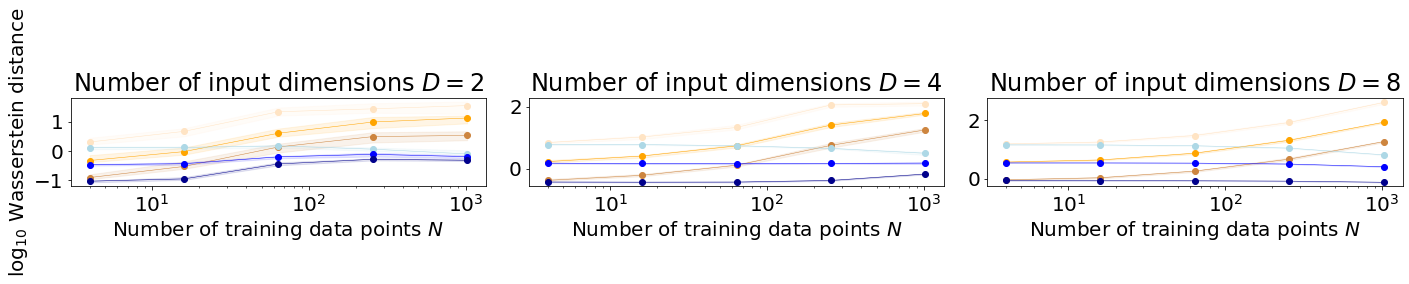

In [58]:
# create plots
fig, axs = plt.subplots(1, len(num_input_dimensions))
for i in range(len(num_input_dimensions)):
    axs[i].set_title('Number of input dimensions $D=' + str(num_input_dimensions[i]) + '$')
    axs[i].set_xlabel('Number of training data points $N$')
    axs[i].set_xscale('log')
axs[0].set_ylabel('$\log_{10}$ Wasserstein distance')

# conduct experiments and plot results
for i in range(len(num_input_dimensions)):  # iterate through the different number of input dimensions
    approx_results, matheron_results = conduct_experiment_for_different_num_features(
        num_input_dimensions=num_input_dimensions[i]
    )
    
    # plot the results for the analytic solution using the weight space approximated kernel
    colors = ['bisque', 'orange', 'peru']
    assert len(colors) ==  len(num_features), "Number of colors must equal the number of features!"
    for j in range(len(approx_results)):
        approx_result = approx_results[j]
        axs[i].fill_between(
            num_train_samples, approx_result[0], approx_result[2], color=colors[j], alpha=0.1
        )
        axs[i].plot(num_train_samples, approx_result[1], 'o', color=colors[j])
        axs[i].plot(num_train_samples, approx_result[1], color=colors[j], linewidth=0.5)

    # plot the results for the Matheron approximation
    colors = ['lightblue', 'blue', 'darkblue']
    assert len(colors) ==  len(num_features), "Number of colors must equal the number of features!"
    for j in range(len(matheron_results)):
        matheron_result = matheron_results[j]
        axs[i].fill_between(
            num_train_samples, matheron_result[0], matheron_result[2], color=colors[j], alpha=0.1
        )
        axs[i].plot(num_train_samples, matheron_result[1], 'o', color=colors[j])
        axs[i].plot(num_train_samples, matheron_result[1], color=colors[j], linewidth=0.5)

# show plots
plt.show()